In [28]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, ttest_rel

# ---------- paths
PATHS = {
    "scFoundation (Raw SC)": "01_simple_baselines/results/elastic_net/scfoundation_10_fold_raw_embeddings_30_pcs_tissue_growth.csv",
    "scFoundation (Preproc SC)": "01_simple_baselines/results/elastic_net/scfoundation_10_fold_embeddings_30_pcs_tissue_growth.csv",
    "scGPT (Preproc SC)": "01_simple_baselines/results/elastic_net/scgpt_10_fold_embeddings_30_pcs_tissue_growth.csv",
}


In [33]:
# %%
def load_results(path, label):
    df = pd.read_csv(path)
    # Normalize column names
    df.rename(columns=lambda c: c.strip().replace("²", "^2"), inplace=True)
    if "r2_mean" not in df.columns and "r2_global" in df.columns:
        df = df.rename(columns={"r2_global":"r2_mean", "rmse":"rmse_mean"})
    needed = {"DRUG_ID","n_samples","r2_mean","rmse_mean","pearson_r","pearson_pval"}
    missing = sorted(list(needed - set(df.columns)))
    if missing:
        raise ValueError(f"Missing columns in {path}: {missing}")
    df["Model"] = label
    return df[["DRUG_ID","n_samples","r2_mean","rmse_mean","pearson_r","pearson_pval","Model"]]

frames = [load_results(p, m) for m,p in PATHS.items()]
all_df = pd.concat(frames, ignore_index=True)
print("✅ combined:", all_df.shape)
all_df.head()


✅ combined: (1875, 7)


,DRUG_ID,n_samples,r2_mean,rmse_mean,pearson_r,pearson_pval,Model
0,133,132,0.062179,1.640831,0.265119,0.002125,scFoundation (Raw SC)
1,134,132,0.018867,1.894260,0.214437,0.013547,scFoundation (Raw SC)
2,135,131,0.002719,2.606634,0.188906,0.030703,scFoundation (Raw SC)
3,136,133,-0.026048,1.526373,0.136858,0.116223,scFoundation (Raw SC)
4,140,133,0.007956,1.631817,0.185500,0.032542,scFoundation (Raw SC)


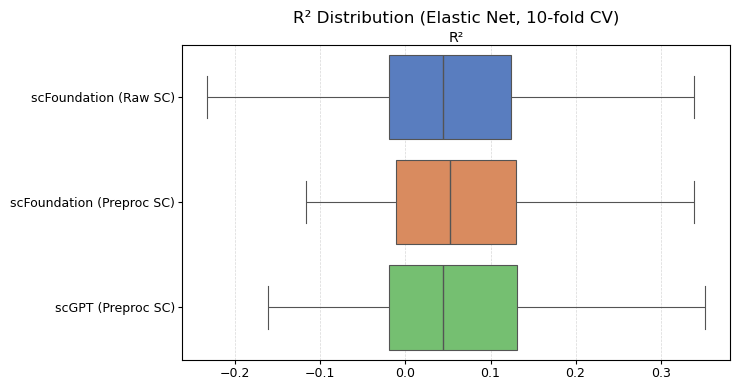

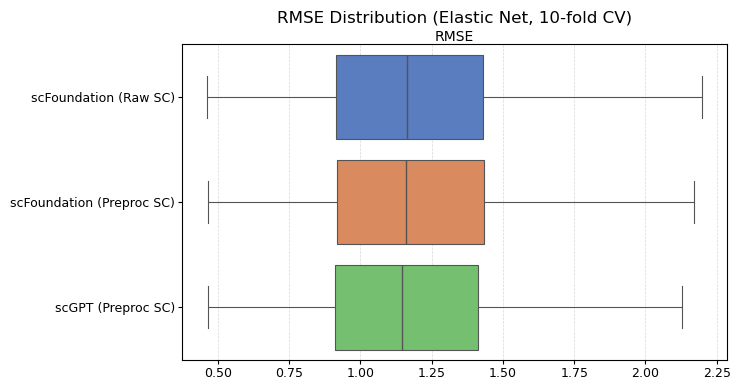

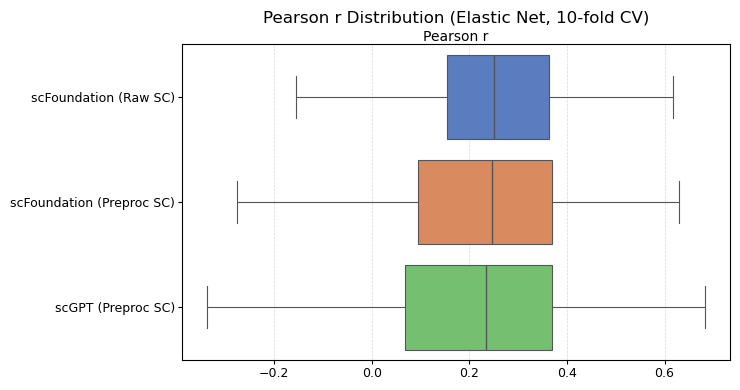

In [34]:
# %%
def nice_boxplot(df, x, title):
    fig, ax = plt.subplots(figsize=(7.5, 4))
    sns.boxplot(
        data=df, x=x, y="Model", hue="Model",
        palette="muted", showfliers=False, dodge=False, ax=ax,
        boxprops=dict(linewidth=0.8),
        whiskerprops=dict(linewidth=0.8),
        capprops=dict(linewidth=0.8),
        medianprops=dict(linewidth=1.0),
    )
    ax.set_title(title, fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel({"r2_mean":"R²", "rmse_mean":"RMSE", "pearson_r":"Pearson r"}[x],
                   fontsize=10, labelpad=2)
    ax.set_ylabel("")
    ax.legend([],[], frameon=False)  # remove redundant legend
    for sp in ax.spines.values(): sp.set_linewidth(0.8)
    ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
    ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)
    plt.tight_layout(); plt.show()

nice_boxplot(all_df, "r2_mean",    "R² Distribution (Elastic Net, 10-fold CV)")
nice_boxplot(all_df, "rmse_mean",  "RMSE Distribution (Elastic Net, 10-fold CV)")
nice_boxplot(all_df, "pearson_r",  "Pearson r Distribution (Elastic Net, 10-fold CV)")


In [35]:
# %%
def agg_stats(df, metric):
    g = df.groupby(["Model"], as_index=False)[metric].agg(mean="mean", std="std", n="count")
    g["se"] = g["std"] / np.sqrt(g["n"])
    g["ci95"] = 1.96 * g["se"]
    g["metric"] = metric
    return g.rename(columns={"mean":"Mean","std":"Std","n":"N","ci95":"95% CI"})

summary_table = pd.concat([
    agg_stats(all_df, "r2_mean"),
    agg_stats(all_df, "rmse_mean"),
    agg_stats(all_df, "pearson_r"),
], ignore_index=True)

display(summary_table[["metric","Model","N","Mean","Std","95% CI"]].round(4))


,metric,Model,N,Mean,Std,95% CI
0,r2_mean,scFoundation (Preproc SC),625,0.0703,0.1018,0.0080
1,r2_mean,scFoundation (Raw SC),625,0.0554,0.1113,0.0087
2,r2_mean,scGPT (Preproc SC),625,0.0662,0.1090,0.0085
3,rmse_mean,scFoundation (Preproc SC),625,1.1879,0.3738,0.0293
4,rmse_mean,scFoundation (Raw SC),625,1.1969,0.3765,0.0295
5,rmse_mean,scGPT (Preproc SC),625,1.1893,0.3739,0.0293
6,pearson_r,scFoundation (Preproc SC),625,0.2249,0.1987,0.0156
7,pearson_r,scFoundation (Raw SC),625,0.2540,0.1532,0.0120
8,pearson_r,scGPT (Preproc SC),625,0.2136,0.2087,0.0164


In [36]:
# %%
sig_rates = (
    all_df.assign(sig_pearson = all_df["pearson_pval"] < 0.05)
           .groupby("Model")
           .agg(pearson_rate=("sig_pearson","mean"),
                N=("sig_pearson","count"))
           .reset_index()
)
sig_rates["pearson_rate"] = (100*sig_rates["pearson_rate"]).round(1)
sig_rates.rename(columns={"pearson_rate":"% Pearson p<0.05"}, inplace=True)
display(sig_rates)


,Model,% Pearson p<0.05,N
0,scFoundation (Preproc SC),68.5,625
1,scFoundation (Raw SC),70.1,625
2,scGPT (Preproc SC),65.4,625
